## PGC Dynamic STAC API Tutorial
### How to query and fetch PGC Digital Elevation Models (DEMs) with python

The [Polar Geospatial Center](https://www.pgc.umn.edu) produces DEMs from high resolution satellite imagery and makes them publicly available for the polar regions through the [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/) and [Reference Elevation Model of Antarctica (REMA)](https://www.pgc.umn.edu/data/rema/) products, as well as a subset of the [EarthDEM](https://www.pgc.umn.edu/data/earthdem/) data for the area around the Great Lakes region that is publicly available. These are continent-scale, high resolution (2m), repeat coverage elevation models published as time-stamped DEM Strips and (mostly) seamless Mosaics. You can find out more about [this elevation data on our website](https://www.pgc.umn.edu/data/elevation/). 

There are several methods for viewing and downloading the data, but this notebook will focus on how to leverage the dynamic STAC API to query the datasets and retrieve the data you want within a python environment to integrate with geospatial workflows. The data is hosted on the AWS Registry of Open Data ([ArcticDEM](https://registry.opendata.aws/pgc-arcticdem/) and [REMA](https://registry.opendata.aws/pgc-rema/)), where you can browse a static version of the STAC catalog to preview the data or find the link to the dynamic STAC API that we will be demonstrating here. 

### What is STAC?
STAC - [Spatio Temporal Asset Catalog](https://stacspec.org/en) is a standard for organizing geospatial data for convenient access. Essentially, it is a set of GeoJSON-formatted metadata describing location and time for geospatial information, with links to the actual data, organized within sets of Catalogs and Collections. We will look at each of these in turn using python tools to query the API.

### Importing Libraries for STAC API
The first step is to import the necessary pyton libraries for interacting with the API. We will be using the pystac_client library to connect to the PGC STAC Catalog through the API url: `https://stac.pgc.umn.edu/api/v1/`

We will build a query for the STAC API based on geographic location in two ways: frist, by zooming to our area of interest in a webmap within the notebook and second, by defining an area from a shapefile.

Once the API returns the list of DEM items, we will load the metadata into a geopandas dataframe to look at the attributes and finally into an xarray dataset where we can visualize the data and pass it on to any downstream data analysis/processing.

Detailed documentation for the libraries used in this tutorial and additional example workflows can be found at their respective websites:

 - [pystac_client](https://pystac-client.readthedocs.io/en/stable/) - interact with the STAC API
 - [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) - extension of the leaflet mapping library to make interactive web maps within the jupyter notebook for spatial querying
 - [stackstac](https://stackstac.readthedocs.io/en/latest/index.html#) - read STAC API datasets into xarray data structures
 - [xarray](https://docs.xarray.dev/en/stable/) - work with multidimensional arrays, lazy loading, and parallel processing - great for geospatial raster data

In [24]:
# access the STAC API and build a search query
import pystac_client
import ipyleaflet

# read the data for analysis and visualization
import stackstac
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# print figures within the jupyter notebook
%matplotlib inline

#### Catalogs

The top level organization of the PGC STAC is the Catalog. This top level contains information about the API itself and the data contained within it, kind of like the top level of a file directory with lots of content organized within. We will load the catalog and take a look at the contents using built in methods from the `pystac_client` library.

Since we are only reading metadata, this data exploration happens almost immediately without having to load any of the actual data.


In [23]:
# access the PGC Data Catalog API
cat = pystac_client.Client.open("https://stac.pgc.umn.edu/api/v1/")

cat

<Client id=pgc-data-stac>

#### Collections

Next, let's look at the collections available within the PGC Catalog. These represent the different products available through the API, broken out by region (ArcticDEM, REMA, and EarthDEM) and product type (DEM Strips and DEM Mosaics) at different resolutions. 

In [3]:
# see the available collections in the catalog
for collection in cat.get_collections():
    print(collection)

<CollectionClient id=arcticdem-mosaics-v3.0-2m>
<CollectionClient id=arcticdem-mosaics-v3.0-10m>
<CollectionClient id=arcticdem-mosaics-v3.0-32m>
<CollectionClient id=arcticdem-mosaics-v4.1-2m>
<CollectionClient id=arcticdem-mosaics-v4.1-10m>
<CollectionClient id=arcticdem-mosaics-v4.1-32m>
<CollectionClient id=arcticdem-strips-s2s041-2m>
<CollectionClient id=earthdem-strips-s2s041-2m>
<CollectionClient id=rema-mosaics-v2.0-2m>
<CollectionClient id=rema-mosaics-v2.0-10m>
<CollectionClient id=rema-mosaics-v2.0-32m>
<CollectionClient id=rema-strips-s2s041-2m>


In [27]:
# Filter the collections to view just the REMA datasets
collection_search = cat.collection_search(
    q="rema",
)

for result in collection_search.collections():
    print(result.id, f"{result.description}", sep="\n")
    print("\n")

C:\Users\bakke557\AppData\Local\mambaforge\envs\pgc_plus\Lib\site-packages\pystac_client\collection_search.py:292: UserWarning: Server does not conform to COLLECTION_SEARCH. Filtering will be performed client-side where only bbox, datetime, and q arguments are supported
  warnings.warn(


rema-mosaics-v2.0-2m
REMA DEM mosaics, version 2.0, 2m resolution


rema-mosaics-v2.0-10m
REMA DEM mosaics, version 2.0, 10m resolution


rema-mosaics-v2.0-32m
REMA DEM mosaics, version 2.0, 32m resolution


rema-strips-s2s041-2m
REMA time-stamped strip DEMs, s2s version 4.1, 2m resolution




In [5]:
# get the REMA strips collection
rema_strips_col = cat.get_collection("rema-strips-s2s041-2m")
rema_strips_col

<CollectionClient id=rema-strips-s2s041-2m>

#### Items
Finally, we have the items. Each individual data file--in this case a DEM strip or mosaic tile--is represented as a STAC Item. These Items have all the attributes of the DEM files along with links for accessing the data from the cloud directly, as we will show here, or downloading it to use locally. 

To access the items, we will walk through a typical workflow to query one of the Collections (REMA 2m DEM Strips), filtering by location, time, and data quality.

In [6]:
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = -77.5, 164
m.zoom = 7
m.layout.height = "400px"
m

Map(center=[-77.5, 164], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [12]:
bbox = (m.west, m.south, m.east, m.north)
bbox

(164.32250976562503,
 -77.66825768464919,
 170.34851074218753,
 -77.19008813850427)

In [13]:
search = cat.search(
    collections = ["rema-strips-s2s041-2m"],
    bbox=bbox,
    datetime="2023-01-01/2023-12-31"
)

In [14]:
items = list(search.items())
print(len(items))

69


In [15]:
items[0]

<Item id=SETSM_s2s041_W1W2_20231228_10200100E68DA500_10300100F3120F00_2m_seg1>

In [16]:
items[0].links

[<Link rel=collection target=https://stac.pgc.umn.edu/api/v1/collections/rema-strips-s2s041-2m>,
 <Link rel=parent target=https://stac.pgc.umn.edu/api/v1/collections/rema-strips-s2s041-2m>,
 <Link rel=root target=<Client id=pgc-data-stac>>,
 <Link rel=self target=https://stac.pgc.umn.edu/api/v1/collections/rema-strips-s2s041-2m/items/SETSM_s2s041_W1W2_20231228_10200100E68DA500_10300100F3120F00_2m_seg1>]

In [17]:
items_gdf = gpd.GeoDataFrame.from_features(search.item_collection().to_dict(), crs="epsg:4326").to_crs(3031)
items_gdf

,geometry,gsd,title,created,license,pgc:rmse,proj:code,published,pgc:is_lsf,proj:shape,...,pgc:valid_area_sqkm,pgc:water_area_sqkm,pgc:cloud_area_percent,pgc:valid_area_percent,pgc:water_area_percent,pgc:avg_convergence_angle,pgc:masked_matchtag_density,pgc:valid_area_matchtag_density,pgc:avg_expected_height_accuracy,datetime
0,"MULTIPOLYGON Z (((217076 -1331886 0, 216652 -1...",2.0,SETSM_s2s041_W1W2_20231228_10200100E68DA500_10...,2024-03-27T05:56:31Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:05:55Z,False,"[6724, 10528]",...,131.104244,0.000000,0.390356,0.609644,0.000000,21.756863,0.539133,0.884341,1.839428,None
1,"MULTIPOLYGON Z (((-1372 1368962 0, -1372 13720...",2.0,SETSM_s2s041_W3W3_20231224_104001008F3DB100_10...,2024-02-17T10:29:32Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:04:05Z,False,"[5530, 1752]",...,38.154284,0.000000,0.000000,1.000000,0.000000,17.056286,0.996159,0.996159,2.357402,None
2,"MULTIPOLYGON Z (((-1310 1380792 0, -1310 13845...",2.0,SETSM_s2s041_W3W3_20231224_104001008F3DB100_10...,2024-02-17T10:29:36Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:04:05Z,False,"[5759, 1718]",...,39.038600,0.000000,0.000000,1.000000,0.000000,19.416746,0.998553,0.998553,2.066242,None
3,"MULTIPOLYGON Z (((0 -1392738.922 0, -1110 1392...",2.0,SETSM_s2s041_W3W3_20231224_104001008F3DB100_10...,2024-02-17T10:29:48Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:04:05Z,False,"[12802, 1791]",...,88.727986,0.000000,0.000000,1.000000,0.000000,22.633604,0.992577,0.992577,1.770094,None
4,"MULTIPOLYGON Z (((359070 -1302684 0, 356790 -1...",2.0,SETSM_s2s041_W2W3_20231216_10300100F2BEEE00_10...,2024-02-17T09:53:25Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:05:50Z,False,"[7360, 8272]",...,160.812932,0.000000,0.000000,1.000000,0.000000,25.595867,0.995814,0.995814,1.556196,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"MULTIPOLYGON Z (((313048 -1318476 0, 301738 -1...",2.0,SETSM_s2s041_WV02_20230104_10300100DF63E700_10...,2023-05-29T21:21:36Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:05:52Z,False,"[50904, 20528]",...,1397.108032,22.138680,0.200388,0.788518,0.012495,36.104523,0.768546,0.974671,1.084599,None
65,"MULTIPOLYGON Z (((314904 -1309122 0, 326348 -1...",2.0,SETSM_s2s041_WV02_20230103_10300100E096C300_10...,2023-05-29T21:27:00Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:05:52Z,False,"[50505, 20233]",...,1408.417648,0.000000,0.251672,0.748328,0.000000,38.768783,0.718193,0.959730,1.004719,None
66,"MULTIPOLYGON Z (((238750 -1369880 0, 236734 -1...",2.0,SETSM_s2s041_WV01_20230103_10200100D1ADEA00_10...,2023-05-29T20:41:41Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:05:55Z,False,"[10259, 11968]",...,155.005672,18.872128,0.502947,0.447746,0.054514,37.656776,0.412878,0.922126,1.036715,None
67,"MULTIPOLYGON Z (((239312 -1373100 0, 239592 -1...",2.0,SETSM_s2s041_WV01_20230103_10200100D1ADEA00_10...,2023-05-29T20:40:47Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:05:55Z,False,"[5057, 11040]",...,76.358308,0.000000,0.376487,0.623513,0.000000,37.449918,0.576270,0.924232,1.042902,None


In [25]:
%%time

stack = stackstac.stack(items[7], epsg=3031)

stack

CPU times: total: 31.2 ms
Wall time: 200 ms


<xarray.DataArray 'stackstac-e4853ec22714d5f2ecaad6b3c451e36e' (time: 1,
                                                                band: 5,
                                                                y: 7220, x: 9444)> Size: 3GB
dask.array<fetch_raster_window, shape=(1, 5, 7220, 9444), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                              (time) datetime64[ns] 8B NaT
    id                                (time) <U68 272B 'SETSM_s2s041_W2W2_202...
  * band                              (band) <U16 320B 'dem' ... 'hillshade_m...
  * x                                 (x) float64 76kB 2.436e+05 ... 2.631e+05
  * y                                 (y) float64 58kB -1.337e+06 ... -1.352e+06
    gsd                               (band) object 40B None None None 10.0 10.0
    ...                                ...
    pgc:rmse                          int32 4B -9999
    title                             (band) <U20 400B '2m DEM' ... 'Masked 1...
    pgc:geocell                       <U7 28B 's78e169'
    bands                             (band) object 40B {'unit': 'meter', 'no...
    alternate                         (band) object 40B {'s3': {'href': 's3:/...
    epsg                              int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(243639.1380538119, -1351819...
    crs:            epsg:3031
    transform:      | 2.06, 0.00, 243639.14|\n| 0.00,-2.05,-1337012.22|\n| 0....
    resolution_xy:  (2.0631299161146557, 2.050805237720745)

CPU times: total: 18.4 s
Wall time: 17.5 s


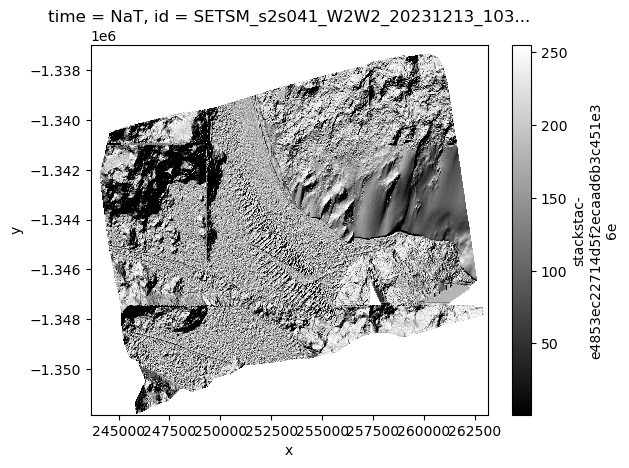

In [26]:
%%time

stack.sel(band='hillshade').plot(cmap='gist_gray')

In [20]:
%%time

stack_all = stackstac.stack(items, epsg=3031)

stack_all

CPU times: total: 62.5 ms
Wall time: 54.4 ms


<xarray.DataArray 'stackstac-2ea8f0e76690f997bde409eaef60fba8' (time: 69,
                                                                band: 5,
                                                                y: 1408569,
                                                                x: 196240)> Size: 763TB
dask.array<fetch_raster_window, shape=(69, 5, 1408569, 196240), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/36)
  * time                              (time) datetime64[ns] 552B NaT NaT ... NaT
    id                                (time) <U68 19kB 'SETSM_s2s041_W1W2_202...
  * band                              (band) <U16 320B 'dem' ... 'hillshade_m...
  * x                                 (x) float64 2MB -1.58e+04 ... 3.772e+05
  * y                                 (y) float64 11MB 1.42e+06 ... -1.397e+06
    gsd                               (band) object 40B None None None 10.0 10.0
    ...                                ...
    pgc:valid_area_matchtag_density   (time) float64 552B 0.8843 ... 0.9884
    pgc:rmse                          int32 4B -9999
    title                             (band) <U20 400B '2m DEM' ... 'Masked 1...
    pgc:geocell                       (time) <U7 2kB 's78e170' ... 's78e169'
    bands                             (band) object 40B {'unit': 'meter', 'no...
    epsg                              int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(-15804.337061718586, -13966...
    crs:            epsg:3031
    transform:      | 2.00, 0.00,-15804.34|\n| 0.00,-2.00, 1420467.28|\n| 0.0...
    resolution_xy:  (2.0028307010161686, 1.9999595612649608)

CPU times: total: 1.67 s
Wall time: 4.07 s


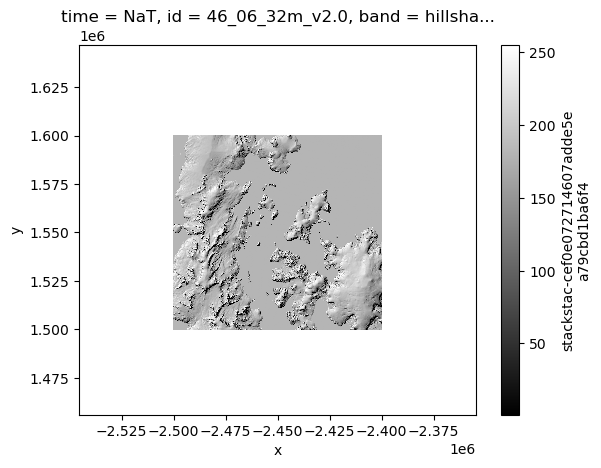

In [77]:
%%time

stack.sel(band='hillshade').plot(cmap='gist_gray')

CPU times: total: 2.08 s
Wall time: 2.71 s


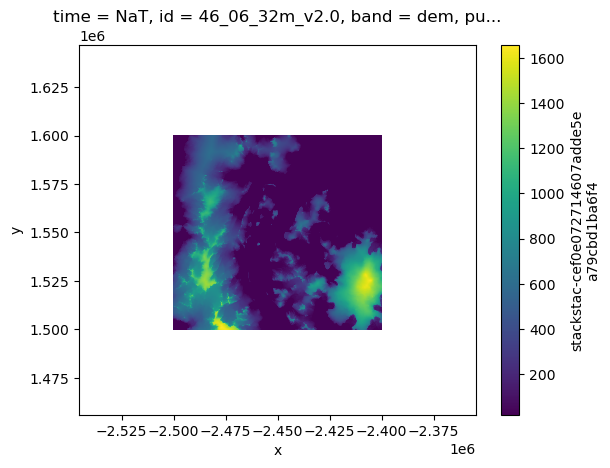

In [67]:
%%time

stack.sel(band='dem').plot()

In [21]:
# note that we need to use the same projection for the layer and the map.
m2 = ipyleaflet.Map(
    center=(-64, -58),
    zoom=8,
    basemap=ipyleaflet.basemaps.Esri.AntarcticBasemap,
    crs=ipyleaflet.projections.EPSG3031.ESRIBasemap,
)

# add draw control on Antarctic map
def handle_draw(target, action, geo_json):
    print(action, geo_json)
    
dc2 = ipyleaflet.DrawControl(marker={"shapeOptions": {"color": "#0000FF"}})
dc2.on_draw(handle_draw)
m2.add(dc2)

# MODIS Mosaic of Antarctica (MOA)
MOA3031 = dict(
    name="EPSG:3031",
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds=[[-3174450, -2816050], [2867175, 2406325]],
)

MOA = ipyleaflet.WMSLayer(
    attribution="""
        U.S. Geological Survey (USGS), British Antarctic Survey (BAS),
        National Aeronautics and Space Administration (NASA)
        """,
    layers="MOA_125_HP1_090_230",
    format="image/png",
    transparent=False,
    opacity=0.5,
    url="https://nimbus.cr.usgs.gov/arcgis/services/Antarctica/USGS_EROS_Antarctica_Reference/MapServer/WmsServer",
    crs=MOA3031,
)
# m2.add(MOA)

m2.add(stack.sel(band='hillshade').isel(time=0))

m2

Map(center=[-64, -58], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [93]:
stack.sel(band='hillshade').isel(time=0)

<xarray.DataArray 'stackstac-cef0e072714607adde5ea79cbd1ba6f4' (y: 3132, x: 3132)> Size: 78MB
dask.array<getitem, shape=(3132, 3132), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/26)
    time                 datetime64[ns] 8B NaT
    id                   <U14 56B '46_06_32m_v2.0'
    band                 <U14 56B 'hillshade'
  * x                    (x) float64 25kB -2.545e+06 -2.545e+06 ... -2.355e+06
  * y                    (y) float64 25kB 1.647e+06 1.647e+06 ... 1.456e+06
    published            <U20 80B '2022-08-24T20:14:42Z'
    ...                   ...
    pgc:release_version  <U3 12B '2.0'
    constellation        <U5 20B 'maxar'
    pgc:tile             <U5 20B '46_06'
    alternate            object 8B {'s3': {'href': 's3://pgc-opendata-dems/re...
    bands                object 8B {'unit': 'meter', 'nodata': 0, 'data_type'...
    epsg                 int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(-2545420.207433613, 1455919...
    crs:            epsg:3031
    transform:      | 60.90, 0.00,-2545420.21|\n| 0.00,-60.90, 1646663.85|\n|...
    resolution_xy:  (60.90104812502663, 60.90183625278158)

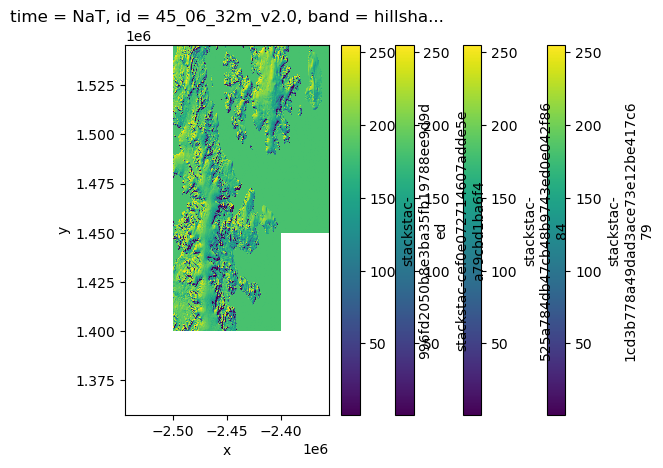

In [50]:
for i in range(len(items)):
    stack = stackstac.stack(items[i], epsg=3031)
    stack.sel(band='hillshade').plot()